In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import climo_utils as cu
import utils
import calc

import plot

In [3]:
cluster, client = utils.get_ClusterClient()
cluster.scale(36) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.63:41208 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/33638/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [5]:
def monthly_clim(ds):
    return ds.groupby('time.month').mean('time')

In [6]:
time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'TEMP',
    'SALT',    
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}-presentday-monclim', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        postprocess=monthly_clim,
    ))
    
ds = xr.merge(ds_list)[['SALT', 'TEMP']]
ds

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/TEMP-presentday-monclim.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/SALT-presentday-monclim.nc


<xarray.Dataset>
Dimensions:    (member_id: 11, month: 12, nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    SALT       (month, member_id, z_t, nlat, nlon) float32 ...
    TEMP       (month, member_id, z_t, nlat, nlon) float32 ...

In [7]:
%%time
def ds_mon_to_ds_season(ds_mon):
    ds_mon = ds_mon.copy()
    ds_mon['season'] = xr.DataArray(['DJF']*2 + ['MAM']*3 + ['JJA']*3 + ['SON']*3 + ['DJF'], dims=('month'))
    ds_mon['dpm'] = xr.DataArray([31., 28., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31.], dims=('month'))
    ds_mon = ds_mon.set_coords(['season', 'dpm'])
    weights = ds_mon.dpm.groupby('season') / ds_mon.dpm.groupby('season').sum()
    np.testing.assert_allclose(weights.groupby('season').sum().values, np.ones(4))
    return (ds_mon * weights).groupby('season').sum(dim='month')

def compute_mld_model(dsigma):
    da_list = []
    for n in range(len(ds.member_id)):
        print(f'member_id {n}')
        da_list.append(
            calc.mld_dsigma(
                ds.SALT.isel(member_id=n).load(), 
                ds.TEMP.isel(member_id=n).load(), 
                dsigma=dsigma,).compute()
        )
    return xr.concat(ds_list, dim='member_id').to_dataset()

mld_list = []
for dsigma in [0.03, 0.125]:
    xp_func = xp.persist_ds(
        compute_mld_model,
        name=f'historical-mld-moc-MLD_{int(dsigma*1e3):03d}', 
        trust_cache=True,
        format='zarr',
    )
    mld_list.append(xp_func(dsigma).rename({'MLD': f'mld_{int(dsigma*1e3):03d}'}))

ds_mld = xr.merge(mld_list)

# convert units
for v in ds_mld.data_vars:
    ds_mld[v] = ds_mld[v] * 1e-2
    ds_mld[v].attrs['units'] = 'm'

ds_mld = ds_mon_to_ds_season(ds_mld).mean('member_id').compute()

for v in ['TLONG', 'TLAT', 'KMT']:
    ds_mld[v] = ds_grid[v]
    
ds_mld

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/historical-mld-moc-MLD_030.zarr
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/historical-mld-moc-MLD_125.zarr
CPU times: user 1.56 s, sys: 321 ms, total: 1.88 s
Wall time: 13.5 s


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, season: 4)
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    mld_030  (season, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_125  (season, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    KMT      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [8]:
ds_obs = xr.open_dataset(
    '/glade/p/cgd/oce/projects/cesm2-marbl/woa2018-data/POP_gx1v7/monthly/woa18_derived_MLD.nc',
)
ds_obs = ds_mon_to_ds_season(ds_obs)
ds_obs = ds_obs.rename({k: f'{k}_obs' for k in ds_obs.data_vars})
ds_obs = ds_obs.rename({'lat': 'nlat', 'lon': 'nlon'})
ds_mld = xr.merge((ds_mld, ds_obs))
ds_mld

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, season: 4)
Coordinates:
  * nlat         (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * nlon         (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    mld_030      (season, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mld_125      (season, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    mld_125_obs  (season, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mld_030_obs  (season, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [9]:
client.close()
cluster.close()
del client
del cluster

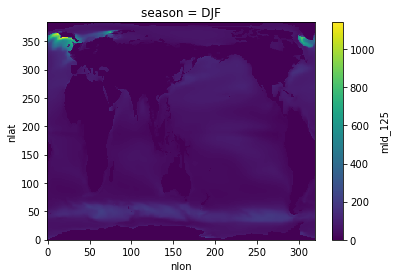

In [10]:
ds_mld.mld_125.sel(season='DJF').plot()

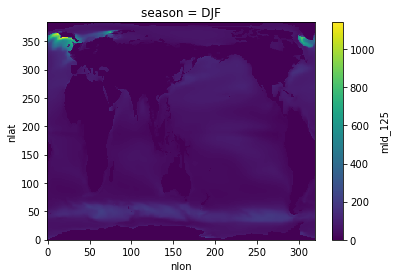

In [11]:
ds_mld.mld_125.sel(season='DJF').plot()

In [31]:
ds_mld_merged = xr.Dataset({k: ds_grid[k] for k in ['TLONG', 'TLAT']})

for v in ['mld_125', 'mld_030', 'mld_125_obs', 'mld_030_obs']:
    ds_mld_merged[f'{v}_summer'] = xr.where(ds_mld.TLAT < 0., ds_mld[v].sel(season='DJF'), ds_mld[v].sel(season='JJA'))
    ds_mld_merged[f'{v}_winter'] = xr.where(ds_mld.TLAT > 0., ds_mld[v].sel(season='DJF'), ds_mld[v].sel(season='JJA'))    
    
ds_mld_merged = utils.pop_add_cyclic(ds_mld_merged.drop(['nlat', 'nlon'])).compute()
ds_mld_merged

<xarray.Dataset>
Dimensions:             (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG               (nlat, nlon) float64 -220.6 -219.4 ... -39.57 -39.86
    mld_125_summer      (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_125_winter      (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_030_summer      (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_030_winter      (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_125_obs_summer  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_125_obs_winter  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_030_obs_summer  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mld_030_obs_winter  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

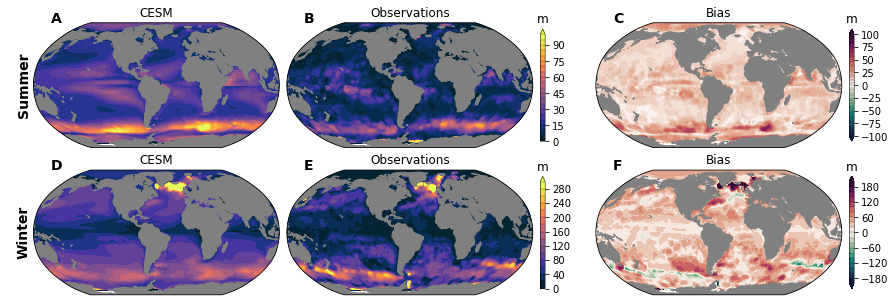

In [46]:
cmap_field = cmocean.cm.thermal
cmap_bias = cmocean.cm.curl

levels = dict(
    Summer=np.arange(0., 105., 5.),
    Winter=np.arange(0., 320., 20.), 
)

levels_bias = dict(
    Summer=np.arange(-100., 105., 5.),
    Winter=np.arange(-200., 220., 20.), 
)    


fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 0.02, 1, 0.02))

prj = ccrs.Robinson(central_longitude=305.0)

axs = []
maps = []
for i, fld in enumerate(['Summer', 'Winter']):
    ax_m = plt.subplot(gs[i, 0], projection=prj)
    ax_o = plt.subplot(gs[i, 1], projection=prj)
    ax_b = plt.subplot(gs[i, 3], projection=prj)
    
    ax_m.set_global()
    ax_o.set_global()
    ax_b.set_global()
    
    cax_field = plt.subplot(gs[i, 2])
    cax_bias = plt.subplot(gs[i, 4])
    
    axs.append((ax_m, ax_o, cax_field, ax_b, cax_bias))
    maps.extend([ax_m, ax_o, ax_b])
    
    cesm = ds_mld_merged[f'mld_030_{fld.lower()}']
    obs = ds_mld_merged[f'mld_030_obs_{fld.lower()}']
    bias = cesm - obs

    cf_m = ax_m.contourf(
        ds_mld_merged.TLONG, ds_mld_merged.TLAT, cesm, 
        levels=levels[fld], 
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[fld], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),
    )
    
    cf_o = ax_o.contourf(
        ds_mld_merged.TLONG, ds_mld_merged.TLAT, obs, 
        levels=levels[fld], 
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[fld], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),        
    )

    cf_b = ax_b.contourf(
        ds_mld_merged.TLONG, ds_mld_merged.TLAT, bias, 
        levels=levels_bias[fld], 
        extend='both',        
        cmap=cmap_bias,
        norm=colors.BoundaryNorm(levels_bias[fld], ncolors=cmap_bias.N),                   
        transform=ccrs.PlateCarree(),        
    )    
    
    for ax in [ax_m, ax_o, ax_b]:
        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )        
        
    ax_m.set_title('CESM')
    ax_o.set_title('Observations')    
    ax_b.set_title('Bias')        
    
    cb_field = plt.colorbar(cf_o, cax=cax_field, drawedges=True)
    cb_field.ax.set_title('m')
    cb_field.outline.set_linewidth(0.5)
    cb_field.dividers.set_linewidth(0.25)    
    
    cb_bias = plt.colorbar(cf_b, cax=cax_bias, drawedges=True)
    cb_bias.ax.set_title('m')
    cb_bias.outline.set_linewidth(0.5)
    cb_bias.dividers.set_linewidth(0.25)    
    
# add a gap between left two columns and right; scale colorbars
gs.update(left=0.05, right=0.95, hspace=0.05, wspace=0.05)
offset = 0.05
cax_vert_shrink = 0.8
for i in range(len(axs)):
    
    # the row of axis objects
    ax_m, ax_o, cax_field, ax_b, cax_bias = axs[i]
    
    # shift map
    p0 = ax_b.get_position()
    ax_b.set_position([p0.x0 + offset, p0.y0, p0.width, p0.height])

    # shift and scale colorbar
    p0 = cax_bias.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_bias.set_position([p0.x0 + offset, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

    # scale colorbar    
    p0 = cax_field.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_field.set_position([p0.x0, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])


utils.subplot_row_labels([maps[i] for i in [0, 3]], ['Summer', 'Winter'], xoff=40)
utils.label_plots(fig, maps, xoff=0.02, yoff=0)   

utils.savefig('mld-maps.pdf')